In [1]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [10, 5]

# Individual-based models

Let's start with a simple model of the size of population of organisms.
We'll ignore sex (so, suppose these are hermaphroditic).

## Population growth

Each year, each individual will

1. maybe reproduce, and then
2. maybe die.

To make a *model* we need to decide exactly how those steps happen.
How about:

1. Each individual produces a random, Poisson number of offspring, with mean $\lambda$, and then
2. survives with probability $p$ (or else, dies).
3. Every individual does this *independently* of everyone else.


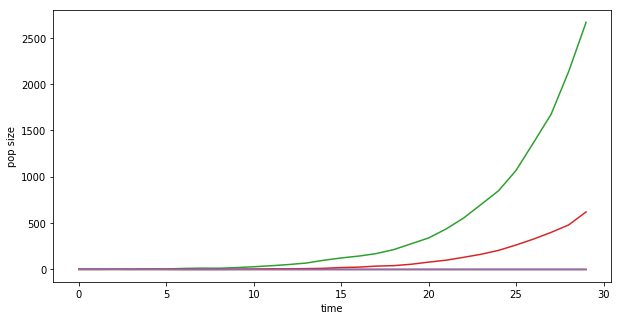

In [3]:
def exp_gen(N, lam, p):
    offspring = np.random.poisson(lam, N)
    survivors = (np.random.uniform(0, 1, N) < p)
    return sum(offspring) + sum(survivors)
    

# run five simulations
N = np.empty((30,5), dtype='int')
N[0, :] = 1
for t in range(1, len(N)):
    for k in range(N.shape[1]):
        N[t, k] = exp_gen(N[t-1, k], 
                          lam=0.5, # mean offspring / year
                          p=0.75) # mean lifetime is 1/(1-p)
    
plt.plot(N)
plt.xlabel("time")
plt.ylabel("pop size")
plt.show()

## Population regulation

Those populations grew exponentially, if they didn't die out.
What if we want a *stable* population?
Let's say that there's "room" for around $K$ individuals, total,
and so that each new individual finds "space" to live with probability $1 - N/K$
when there's $N$ adults present.
So, 
1. Each individual produces a random, Poisson number of offspring, with mean $\lambda$, and then
2. each adult survives with probability $p$ (or else, dies), while
3. each new offspring survives with probability $1-N/K$, if there are $N$ individuals currently.
4. Every individual does this *independently* of everything else.

This is (a stochastic version of) the **logistic model** of population growth,
with fecundity/recruitment/juvenile mortality regulation.

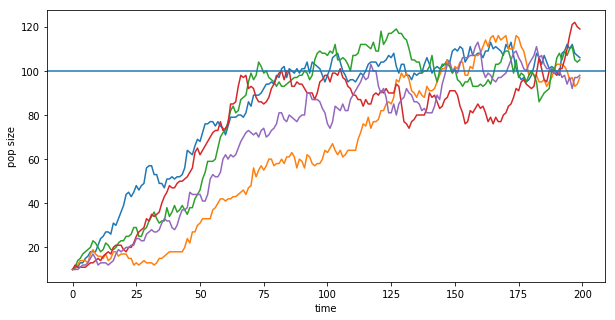

In [4]:
def logistic_gen(N, lam, p, K):
    juveniles = np.random.poisson(lam, N)
    offspring = np.random.binomial(juveniles, 1 - N/K, N)
    survivors = (np.random.uniform(0, 1, N) < p)
    return sum(offspring) + sum(survivors)

# run five simulations
N = np.empty((200, 5), dtype='int')
N[0, :] = 10
for t in range(1, len(N)):
    for k in range(N.shape[1]):
        N[t, k] = logistic_gen(N[t-1, k], lam=0.1, p=0.95, K=200)
    
plt.plot(N, label='logistic growth')
plt.xlabel("time")
plt.ylabel("pop size")
plt.axhline(y=200 * (0.95 + 0.1 - 1) / 0.1)
plt.show()

# Exercise: explore parameter space

How do the three parameters, $\lambda$, $p$, and $K$, affect the dynamics?
For instance:
the stable population size?
the rate of growth when small?
Try to explain *what* and *why*.

# It's equation time

What we're seeing can be thought of as a combination of two things:
a deterministic trend, with randomness on top.
To describe this, we will work out the *mean* and *variance* of the population size at the next time step,
as a function of the current population size:
$$\begin{aligned}
  \mathbb{E}[N_{t+1} | N_t = n] &= F(n) \\
  \text{Var}[N_{t+1} | N_t = n] &= V(n) .
\end{aligned}$$

*(we'll do this on the board)*

In [5]:
def logistic_equil(lam, p, K):
    # return predicted equilibrium
    return K * (lam + p - 1) / lam

# Math: it works

Now we'll see how our math-based predictions match the "reality" of our simulations.

### Speeding this up with probability

But first, let's speed up the code a bit, so we can simulate larger populations.

Above we did `sum(np.random.uniform(0, 1, N) < p)` to find the number of survivors:
all `N` individuals flip `p`-coins to decide if they live or not.
Why, that's just the Binomial($N$, $p$) distribution!
So, we could have just done `np.random.binomial(N, p, 1)`.

Also, we did `sum(np.random.poisson(lam, N)`.
But, what about **additivity of Poissons**?
If $X_1, \ldots, X_n$ are all Poisson random variables,
with means $\lambda_1, \ldots, \lambda_n$ respectively,
then $X_1 + \cdots X_n$ is *also* Poisson, with mean $\lambda_1 + \cdots + \lambda_n$.
That means we could have done `np.random.poisson(N * lam, 1)` instead.

Finally, we will be producing a Poisson number of offspring,
then each one flips a coin to decide whether to survive.
By the **Poisson thinning** property, the resulting random number is *again* Poisson distributed.
In other words, if $N$ is Poisson($\lambda$) and $M$ is Binomial($N$, $q$) given $N$,
then $M$ is Poisson($\lambda q$).

We'll also *vectorize* this, to do many simulations at once.

In [6]:
def logistic_gen(N, lam, p, K):
    return np.random.poisson(lam * N * np.fmax(0.0, 1 - N / K), len(N)) + np.random.binomial(N, p, len(N))

### Time to generalize

And, to save on typing, here's code to "record a bunch of simulations in the columns of an array".

In [7]:
def run_sim(N0, gen_fn, ngens, **kwargs):
    N = np.empty((ngens, len(N0)), dtype='int')
    N[0, :] = N0
    for t in range(1, ngens):
        N[t, :] = gen_fn(N[t-1, :], **kwargs)
    return N

Ok, **now** let's run the simulations:

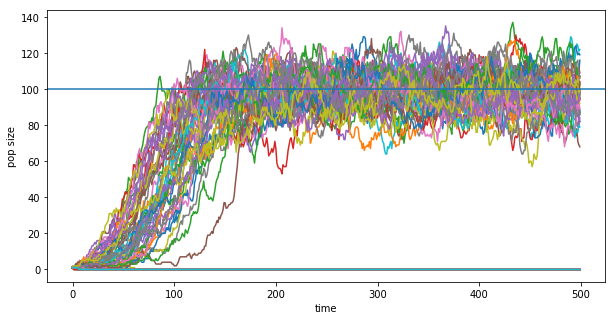

In [8]:
N = run_sim(np.repeat(1, 100), gen_fn=logistic_gen, ngens=500, 
            lam=0.1, p=0.95, K=200)
    
plt.plot(N, label='logistic growth')
plt.axhline(y=logistic_equil(lam=0.1, p=0.95, K=200))
plt.xlabel("time")
plt.ylabel("pop size")
plt.show()

# Logistic cobwebs

First let's look at the function $n \mapsto f(n)$.
We can do this the "math-free" way by just plotting the population size
after one time step of the simulation
starting from a grid of possible initial sizes.

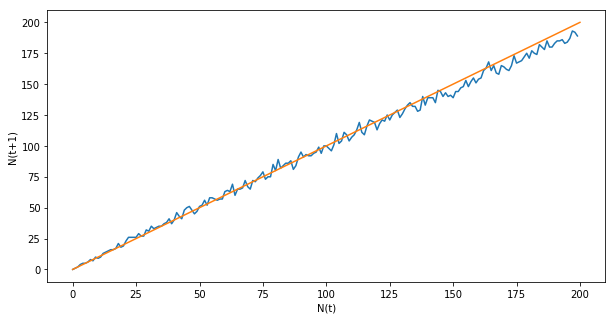

In [9]:
X = np.fromiter(range(200), dtype='int')
Y = logistic_gen(X, lam=0.1, p=0.95, K=200)
plt.plot(X, Y)
plt.plot([0.0, 200], [0.0, 200])
plt.xlabel("N(t)")
plt.ylabel("N(t+1)")
plt.show()

That's hard to see! Let's look at $n \mapsto (f(n) - n)$ instead:

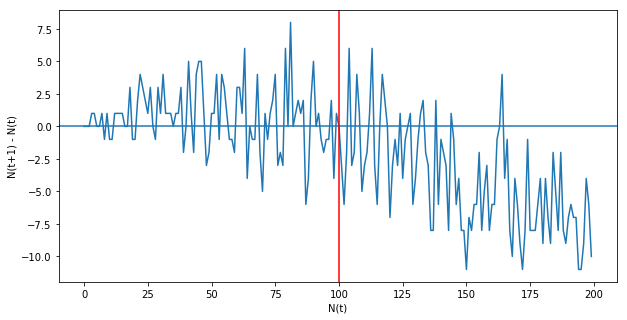

In [10]:
plt.plot(X, Y-X)
plt.axhline(0.0)
plt.axvline(x=logistic_equil(lam=0.1, p=0.95, K=200), color='r')
plt.xlabel("N(t)")
plt.ylabel("N(t+1) - N(t)")
plt.show()

### New parameters

Now let's spice things up by changing the parameters to
$$\begin{aligned}
 \lambda &= 5 \\
 p &= 0.25 \\
 K &= 200
\end{aligned}$$

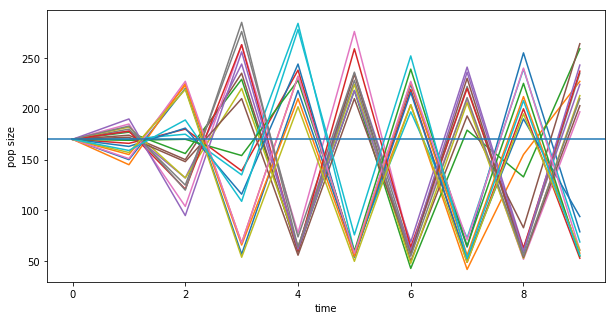

In [11]:
N = run_sim(np.repeat(170, 20), gen_fn=logistic_gen, ngens=10,
            lam=5.0, p=0.25, K=200)
equil = logistic_equil(lam=5.0, p=0.25, K=200)
    
plt.plot(N, label='logistic growth')
plt.axhline(y=equil)
plt.xlabel("time")
plt.ylabel("pop size")
plt.show()

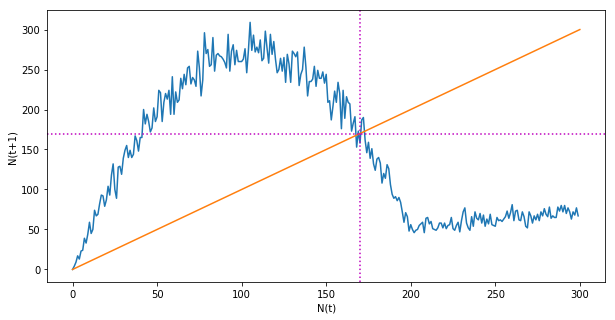

In [12]:
X = np.fromiter(range(300), dtype='int')
Y = logistic_gen(X, lam=5., p=0.25, K=200)

fig, ax = plt.subplots()
ax.plot(X, Y)
ax.plot([0.0, 300], [0.0, 300])
ax.axhline(y=equil, color='m', linestyle="dotted")
ax.axvline(x=equil, color='m', linestyle="dotted")
ax.set_xlabel("N(t)")
ax.set_ylabel("N(t+1)")
plt.show()

**Question:** What's that wierd tail?

### The cobweb plot

Using a plot of the *expected value* curve $f(n) = \mathbb{E}[N_{t+1} | N_t = n]$,
you can trace the expected dynamics
as
$$
 n \mapsto f(n) \mapsto f(f(n)) \mapsto f(f(f(n))) \mapsto \cdots
$$
by "bouncing off the diagonal".

It's easier to explain with a picture.

Population size: [[200  61 259  53 200  43 188  97 296  79]]


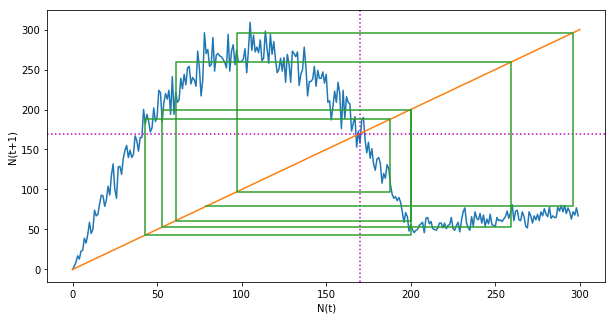

In [18]:
def cobweb_plot(N, ax):
    for k in range(N.shape[1]):
        X = np.repeat(N[:, k], 2)[:-1]
        Y = np.repeat(N[:, k], 2)[1:]
        ax.plot(X, Y)

N = run_sim(np.array([200]), gen_fn=logistic_gen, ngens=10,
            lam=5.0, p=0.25, K=200)     
print("Population size:", N.T)

cobweb_plot(N[:, :1], ax)
fig

# Exercise: dizzy spiders

**Fact:** If the *slope* of $f()$ (the blue curve above)
at the *equilibrium* (the magenta dotted lines) is steeper than $-1$,
then the equilibrium is *unstable*
(and so the population will tend to oscillate around it).

Experiment to convince yourself of this,
then explain why this happens.

# The differential equation version

**The logistic model** of population growth is often defined as the differential equation
$$
 \frac{d}{dt} n(t) = r n(t) \left(1 - \frac{n(t)}{K}\right) .
$$
These are *deterministic*, and also *continuous time*.

What's the relationship?
To get there, we need to reparameterize so that
each time step is *very short*.
Let's say that one old time step is equivalent to $T$ new ones.

**Death:** Before, in a population of size $N$ we'd get about $(1-p)N$ deaths per time step;
so now these should be spread out over $T$ steps.
Setting $p \mapsto 1 - (1-p)/T$ will accomplish this.

**Reproduction:** And, each individual produced a Poisson($\lambda$) number of offspring per time step.
If they don't die, this is equivalent to producing a Poisson($\lambda/T$) number of offspring
in each of $T$ time steps, so we should change $\lambda \mapsto \lambda / T$.

## Rescaling

This leads to the **question:**
What happens to our model if we
1. set one time step to be $1/T$ units of time,
2. reduce the probability of death and mean fecundity by a factor of $T$ per time step,
3. and take $T \to \infty$?

**We'll do this on the board.**

# Miscellanea

The **Ricker model** replaced $1 - N/K$ with $\exp(-N/K)$.
How's it differ? Let's see.

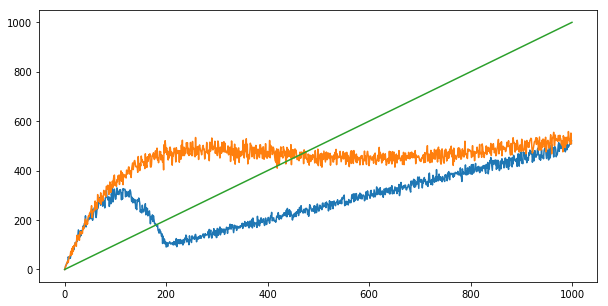

In [19]:
def ricker_gen(N, lam, p, K):
    return np.random.poisson(lam * N * np.exp(- N / K), len(N)) + np.random.binomial(N, p, len(N))

X = np.fromiter(range(1000), dtype='int')
Y = logistic_gen(X, lam=5., p=0.5, K=200)
Z = ricker_gen(X, lam=5., p=0.5, K=200)
plt.plot(X, Y)
plt.plot(X, Z)
plt.plot([0.0, 1000], [0.0, 1000])
plt.show()